# This notebook contains experimentation for cross validation of dirty devil with polynomial feature transformations

### Needed Imports

In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Setting up the style to make the plots look good.
plt.style.use('fivethirtyeight')

# Disabling the deprecation warnings because life is good. 
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Reading in dirty devil data, and combing and removing outliers.

In [625]:
subset1 = pd.read_csv("datasets/freemont_2000-2005_dd_20180410-002554.csv")
subset2 = pd.read_csv("datasets/freemont_dd_20180411-170124")
subset3 = pd.read_csv("datasets/freemont_dd_20180410-213708")
full = pd.concat([subset1, subset2, subset3], ignore_index=True)
del full['Unnamed: 0']

In [626]:
no_outliers = full[full.secs_elapsed.between(100000, 300000)]

In [627]:
x_range = np.arange(np.floor(no_outliers.free_discharge.min()), np.ceil(no_outliers.free_discharge.max()))

### Seperating X and Y values.

In [666]:
Y = no_outliers.secs_elapsed.values
X = no_outliers.free_discharge.values

#### Plot of the default values and testing a simple model over it

[mean: 0.35757, std: 0.18908, params: {'poly_feats__degree': 2}, mean: 0.44535, std: 0.13810, params: {'poly_feats__degree': 3}, mean: 0.36619, std: 0.19684, params: {'poly_feats__degree': 4}, mean: 0.38512, std: 0.22891, params: {'poly_feats__degree': 5}]


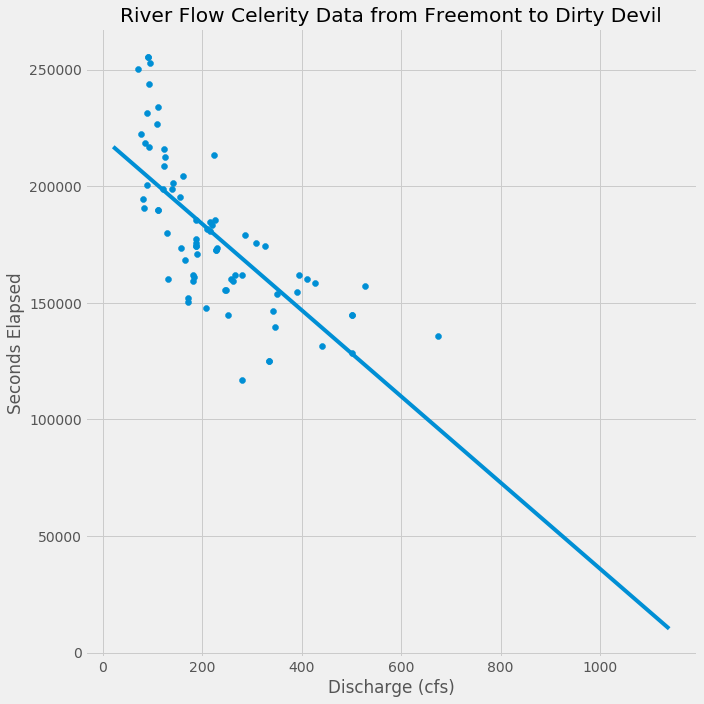

In [667]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.title('River Flow Celerity Data from Freemont to Dirty Devil')
plt.savefig("graphics/celerity_graph.png")
plt.xlabel('Discharge (cfs)')
plt.ylabel('Seconds Elapsed')
lin_reg = LinearRegression()
lin_reg.fit(X[:, np.newaxis], Y[:, np.newaxis])
plt.plot(x_range, lin_reg.predict(x_range[:, np.newaxis]))
cost = np.linalg.norm(Y[:, np.newaxis] - lin_reg.predict(X[:, np.newaxis]))
# Running the Cross Validation to search over the parameter space.
#lin_reg_clf = GridSearchCV(lin_reg,  {}, 
#                           scoring=score_func, 
#                           cv=KFold(n_splits=5, shuffle=True, random_state=45), )
#lin_reg_results = lin_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
#plt.plot(x_range, lin_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
print(lin_reg_clf.grid_scores_)
plt.tight_layout()
plt.savefig("graphics/lin_reg.png")
plt.show()

# Plotting distributions before and after scaling

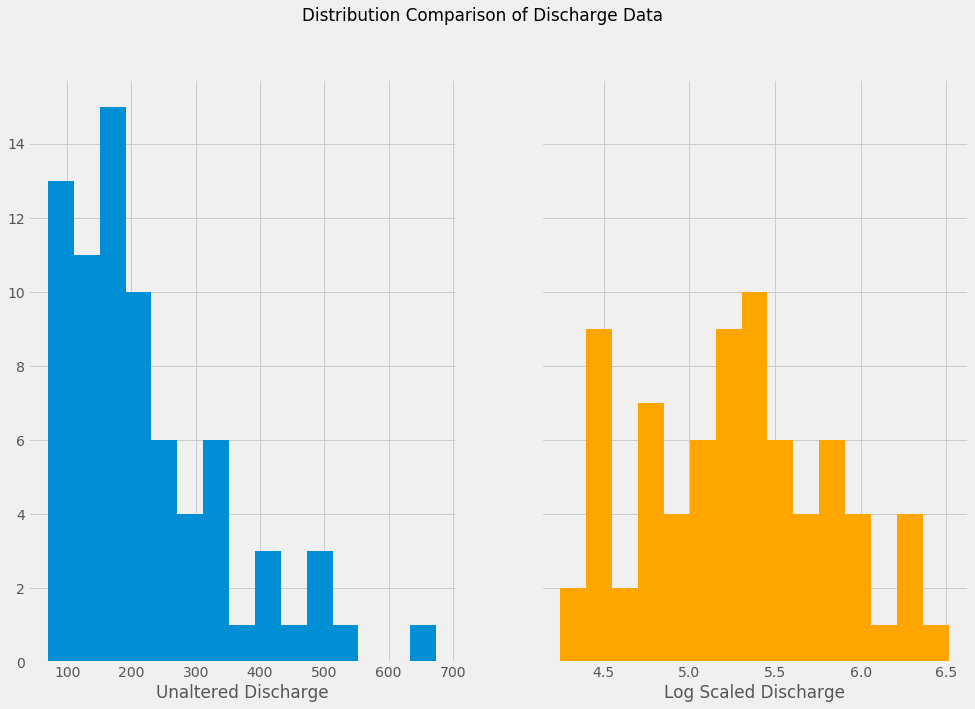

In [669]:
fig, axs = plt.subplots(1, 2, figsize=(15,10), sharey=True)
fig.suptitle('Distribution Comparison of Discharge Data')
axs[0].hist(X,  bins=15, label='Unaltered Discharge Histogram')
axs[0].set_xlabel('Unaltered Discharge')
axs[1].hist(np.log(X),  bins=15, label='Log Scaled Discharge Histogram', color='orange')
axs[1].set_xlabel('Log Scaled Discharge')
plt.savefig('dist_comp.png')
plt.show()

In [670]:
cost

196130.27503630347

### Running Cross k-Fold Cross Validation to find the best parameters for Linear Regression Models

In [671]:
# Function to use to evaluate the score of the model
def score_func(estimator, X, y):
    if -1*np.linalg.norm(estimator.predict(X) - y, 2) > 0:
        print("WTFF")
    return -1*np.sqrt(np.linalg.norm(estimator.predict(X) - y, 2)/len(X))

In [672]:
# Setting up pipeline so data is fed into the polynomial features before going into the regression.
lin_reg_pip = Pipeline([('poly_feats', PolynomialFeatures()), ('regressor', LinearRegression())])

# Running the Cross Validation to search over the parameter space.
lin_reg_clf = GridSearchCV(lin_reg_pip,  {'poly_feats__degree': [2,3,4,5]}, 
                           cv=KFold(n_splits=5, shuffle=True, random_state=45), )
lin_reg_results = lin_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
lin_reg_results.grid_scores_

[mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2},
 mean: 0.55823, std: 0.21098, params: {'poly_feats__degree': 3},
 mean: 0.11379, std: 0.82155, params: {'poly_feats__degree': 4},
 mean: -9.71709, std: 20.39082, params: {'poly_feats__degree': 5}]

In [692]:
lin_reg_results.best_estimator_.steps[1][1].coef_

array([[ 0.00000000e+00, -9.57681854e+02,  2.12078062e+00,
        -1.55860693e-03]])

### Presenting the best estimator

In [673]:
lin_reg_results.best_estimator_

Pipeline(memory=None,
     steps=[('poly_feats', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [674]:
np.linalg.norm(lin_reg_results.best_estimator_.predict(X[:,np.newaxis]) - Y[:, np.newaxis],2)

159098.45829789972

### Plotting the lin regression model

98014841147095.25


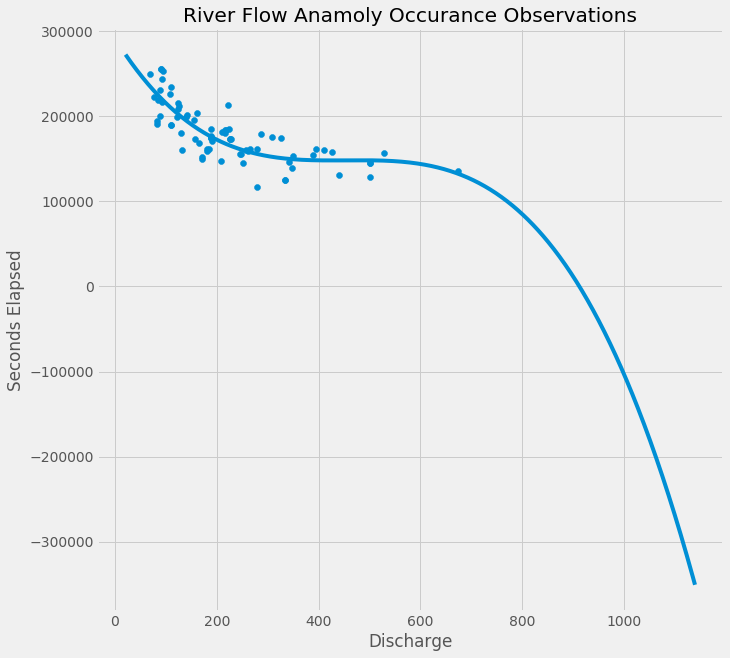

In [675]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, lin_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
print(np.linalg.norm(Y[:, np.newaxis] - lin_reg_clf.predict(Y[:, np.newaxis])))
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.show()

# Running Cross k-Fold Cross Validation to find the best parameters for Ridge Regression Models

In [676]:
ridge_reg_pip = Pipeline([('poly_feats', PolynomialFeatures()), ('regressor', Ridge())])
ridge_reg_clf = GridSearchCV(ridge_reg_pip,  {'poly_feats__degree': [2,3,4,5], 'regressor__alpha': [.0001, .001, .01, .1, 1, 10, 100]},
                             cv=KFold(n_splits=5, shuffle=True, random_state=45))
ridge_reg_results = ridge_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
ridge_reg_results.grid_scores_


[mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.0001},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.001},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.01},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.1},
 mean: 0.54030, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 1},
 mean: 0.54033, std: 0.17823, params: {'poly_feats__degree': 2, 'regressor__alpha': 10},
 mean: 0.54068, std: 0.17797, params: {'poly_feats__degree': 2, 'regressor__alpha': 100},
 mean: 0.55823, std: 0.21098, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.0001},
 mean: 0.55823, std: 0.21098, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.001},
 mean: 0.55823, std: 0.21098, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.01},
 mean: 0.55824, std: 0.21098, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.1},
 

In [696]:
ridge_reg_results.best_estimator_

Pipeline(memory=None,
     steps=[('poly_feats', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('regressor', Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

#### Presenting the best ridge estimator

In [699]:
ridge_reg_results.best_estimator_
ridge_reg_results.best_estimator_.steps[1][1].coef_, lasso_reg_results.best_estimator_.steps[1][1].coef_

(array([[ 0.00000000e+00, -9.49591076e+02,  2.09418868e+00,
         -1.53381726e-03]]),
 array([ 0.00000000e+00, -9.27550933e+02,  2.01860788e+00, -1.46105069e-03]))

In [679]:
np.linalg.norm(ridge_reg_results.best_estimator_.predict(X[:,np.newaxis]) - Y[:, np.newaxis],2)

159100.8728178236

### Plotting the ridge model

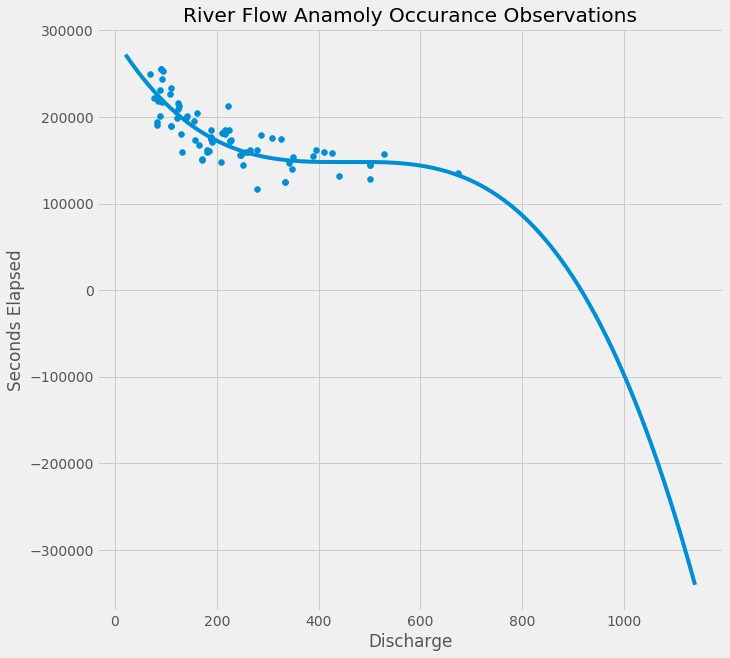

In [680]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, ridge_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.show()

# Running Cross k-Fold Cross Validation to find the best parameters for Lasso Regression Models 

In [681]:
lasso_reg_pip = Pipeline([('poly_feats', PolynomialFeatures()), ('regressor', Lasso())])
lassor_reg_clf = GridSearchCV(lasso_reg_pip,  {'poly_feats__degree': [2,3,4,5], 'regressor__alpha': [.0001, .001, .01, .1, 1, 10]},
                              cv=KFold(n_splits=5, shuffle=True, random_state=45))
lasso_reg_results = lassor_reg_clf.fit(X[:, np.newaxis], Y[:, np.newaxis])
lasso_reg_results.grid_scores_

[mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.0001},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.001},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.01},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 0.1},
 mean: 0.54029, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 1},
 mean: 0.54030, std: 0.17826, params: {'poly_feats__degree': 2, 'regressor__alpha': 10},
 mean: 0.56897, std: 0.21008, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.0001},
 mean: 0.56897, std: 0.21008, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.001},
 mean: 0.56897, std: 0.21008, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.01},
 mean: 0.56897, std: 0.21008, params: {'poly_feats__degree': 3, 'regressor__alpha': 0.1},
 mean: 0.56897, std: 0.21008, params: {'poly_feats__degree': 3, 'regressor__alpha': 1},
 me

### Presenting the best ridge model

In [682]:
lasso_reg_results.best_estimator_.fit(X[:,np.newaxis], Y[:, np.newaxis])

Pipeline(memory=None,
     steps=[('poly_feats', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('regressor', Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [683]:
np.linalg.norm(lasso_reg_results.best_estimator_.predict(X[:,np.newaxis]) - Y[:, np.newaxis],2)

2437773.0493218605

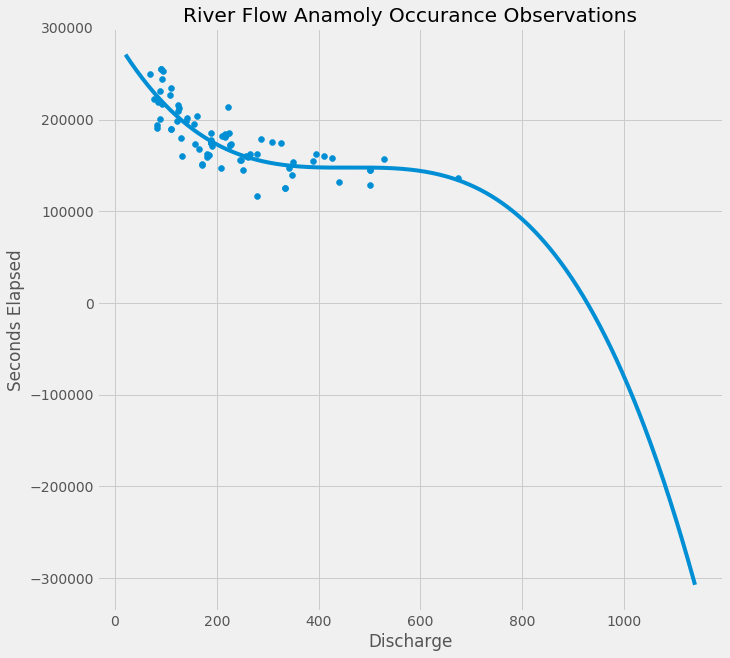

In [686]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.plot(x_range, lasso_reg_results.best_estimator_.predict(x_range[:,np.newaxis]))
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.show()

## Plotting all the best models.

As we can see the best models for each of the models types is not much different.

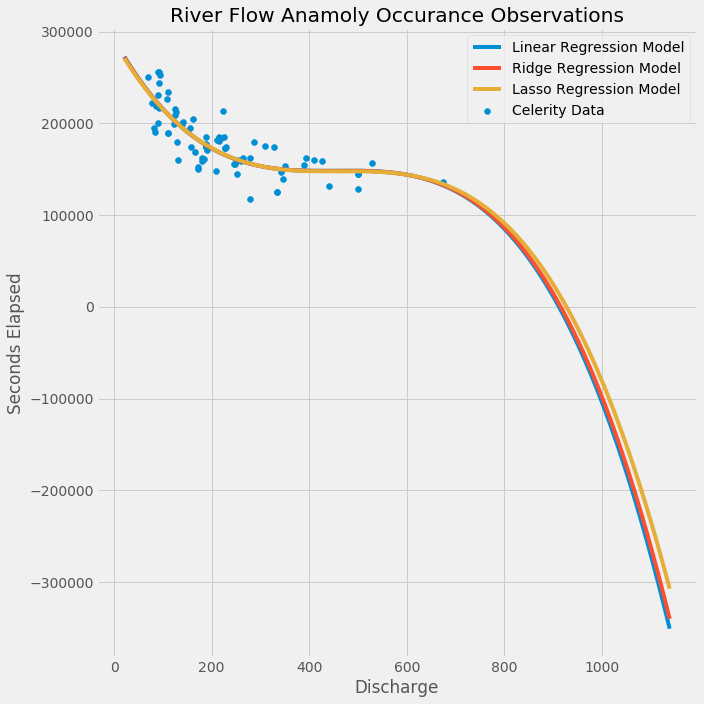

In [687]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, label='Celerity Data')
plt.plot(x_range, lin_reg_results.best_estimator_.predict(x_range[:,np.newaxis]), label='Linear Regression Model')
plt.plot(x_range, ridge_reg_results.best_estimator_.predict(x_range[:,np.newaxis]), label='Ridge Regression Model')
plt.plot(x_range, lasso_reg_results.best_estimator_.predict(x_range[:,np.newaxis]), label='Lasso Regression Model')
plt.title('River Flow Anamoly Occurance Observations')
plt.xlabel('Discharge')
plt.ylabel('Seconds Elapsed')
plt.tight_layout()
plt.legend()
plt.savefig('graphics/combined_poly.png')
plt.show()